# CMA/ES - GORGO 11 - 2nd try: LL median, lapse + sigma_base

Let's see if LL Median behaves well on Gorgo11 also

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [4]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-01a29c85-b4f2-4882-ace1-2548a5254903.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217


In [5]:
dataio = DataIO(label='cmaes_gorgo11', 
                calling_function='', 
                output_folder='./outputs/')

=== FileIO ready: ./outputs/cmaes_gorgo11-4f74bfc2-15d5-4ea0-b6f8-6014a0d68564 ===


In [6]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [7]:
parameter_names_sorted

['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [8]:
metric = 'dist_ll_median'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [9]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [10]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

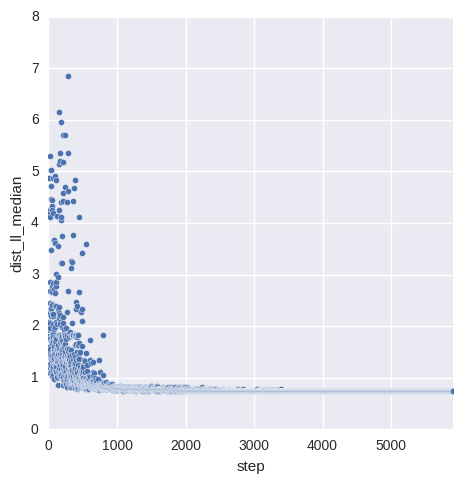

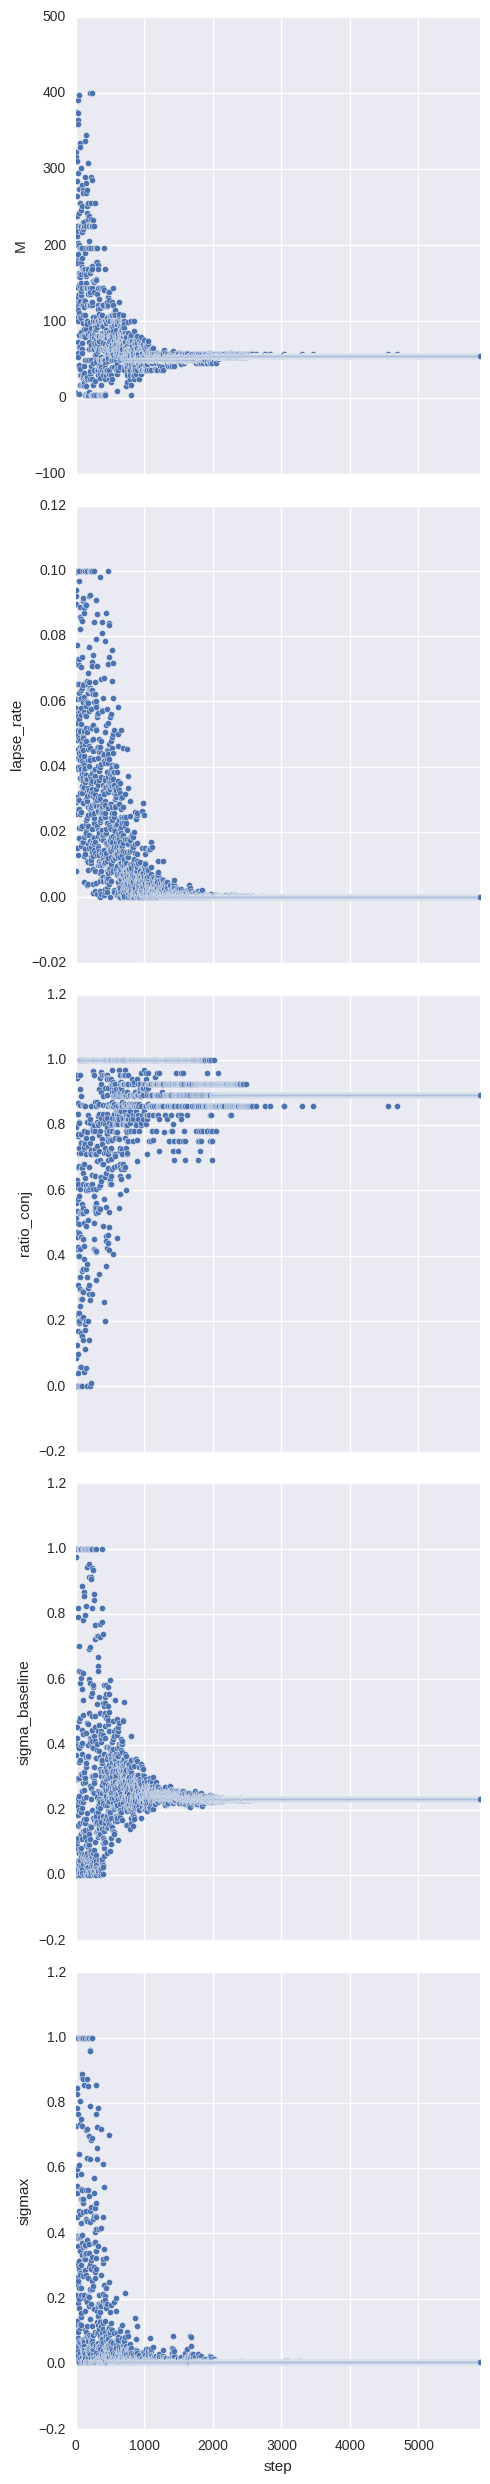

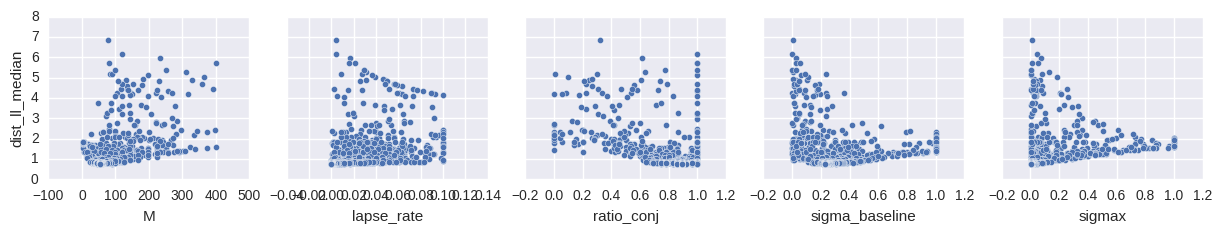

In [11]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [12]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 1000]
result_to_color = np.array(df_cmaes_traj['dist_ll_median'])
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.log(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj['M'],
        y = df_cmaes_traj['lapse_rate'],
        z = df_cmaes_traj['sigma_baseline'],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title='M',
        ),
        yaxis=go.YAxis(
            title='lapse_rate',
        ),
        zaxis=go.ZAxis(
            title='sigma_baseline',
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [15]:
df_topparams = df_best_fits.sort_values(by='step', ascending=False).head(100)
# df_topparams = df_best_fits.sort_values(by=metric, ascending=True).head(100)
params_mean = df_topparams.median()
params_std = df_topparams.std()
for param in parameter_names_sorted + [metric]:
    print("%s   %.4f +- %.4f" % (param, params_mean[param], params_std[param]))

# df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(1).median().to_dict()
# df_bestparams = df_best_fits.sort_values(by=metric).iloc[3].to_dict()
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).iloc[3].to_dict()
df_bestparams

M   55.0000 +- 0.0000
lapse_rate   0.0000 +- 0.0000
ratio_conj   0.8909 +- 0.0000
sigma_baseline   0.2323 +- 0.0000
sigmax   0.0050 +- 0.0000
dist_ll_median   0.7491 +- 0.0000


{'M': 55.0,
 'dist_ll_median': 0.7490694171801516,
 'lapse_rate': 2.1141102363623225e-13,
 'ratio_conj': 0.8909090909090909,
 'sigma_baseline': 0.2323485313537148,
 'sigmax': 0.005,
 'step': 5896.0}

In [31]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='gorgo11',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=2000, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

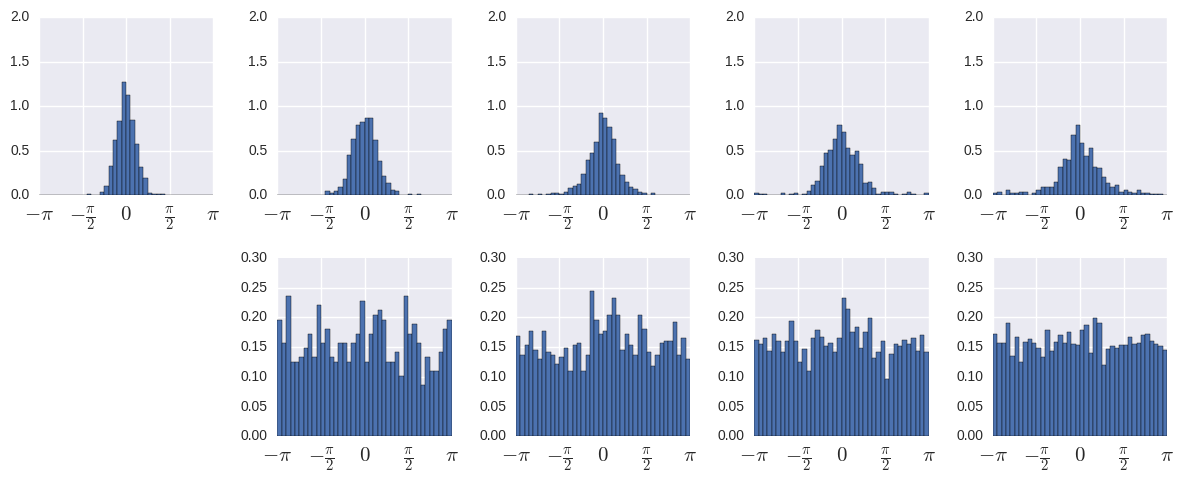

In [32]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()
    axesFig2[0, 0].figure.set_size_inches((12, 5))
    axesFig2[0, 0].figure.suptitle("")
    axesFig2[0, 0].figure.set_tight_layout(True)

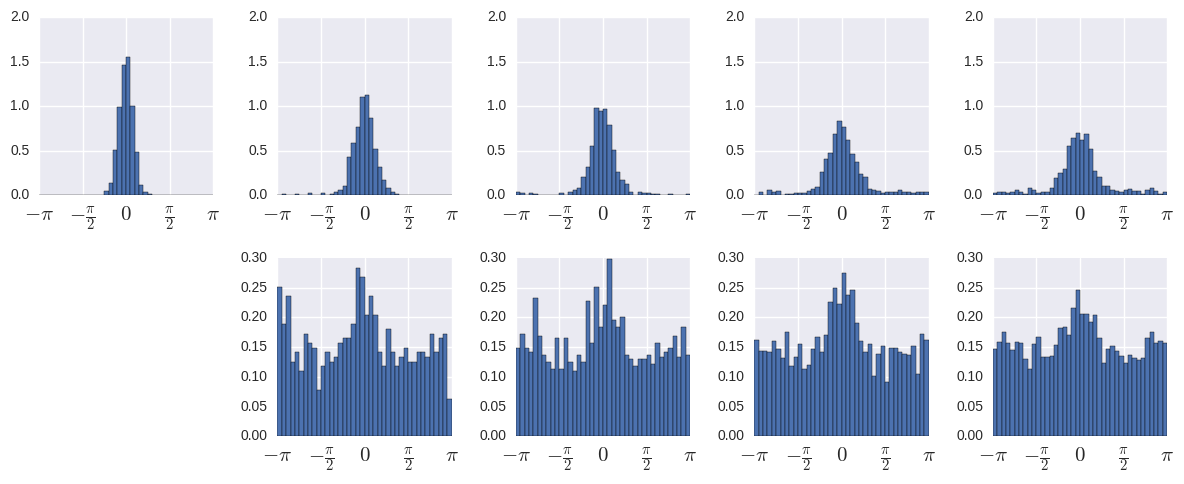

In [33]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()
    axesFig5[0, 0].figure.set_size_inches((12, 5))
    axesFig5[0, 0].figure.suptitle("")
    axesFig5[0, 0].figure.set_tight_layout(True)

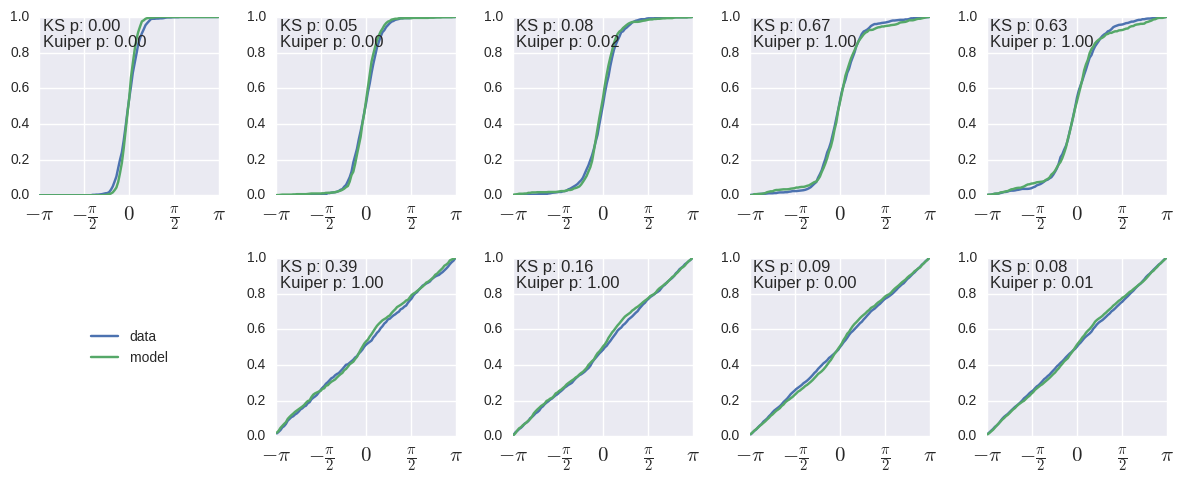

In [34]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((12, 5))
    axes[0, 0].figure.suptitle("")
    axes[0, 0].figure.set_tight_layout(True)

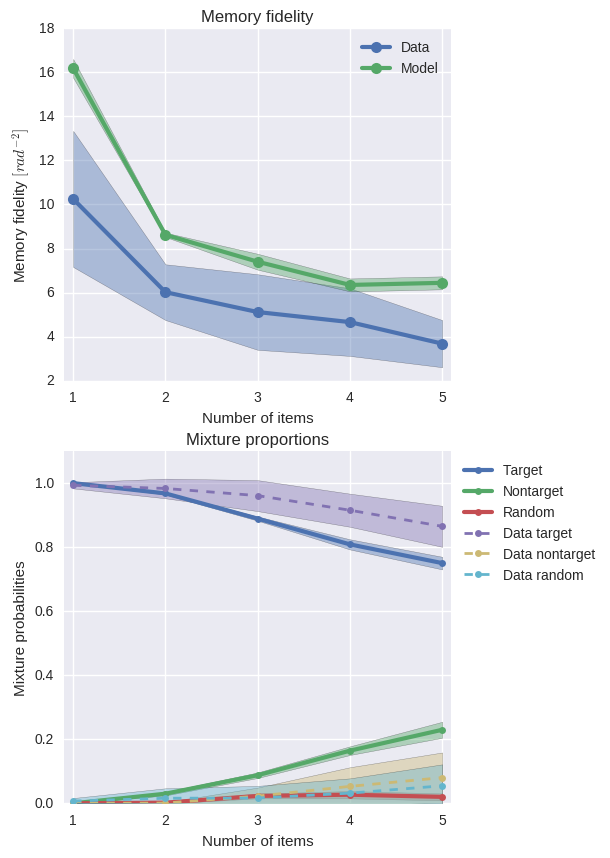

In [18]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Fits are ok, not fantastic but we'll use them


In [29]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_gorgo11_llmedian', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs/thesis_gorgo11_llmedian-018f8e4e-1137-47ee-9e59-4407c4810b9e ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11_2try_llmedian_Mratiosigmaxsigmabaselinelapserate_repetitions3_101217/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/c

In [30]:
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"))
axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"))
axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"))
axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"))

NameError: name 'axesFig6Fig13' is not defined